<table class="table table-bordered">
<tr>
<th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

In [1]:
# import the packages

import findspark 

findspark.init()

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [3]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from datetime import datetime, date
from pyspark.sql import Row
from pyspark.sql import Column
from pyspark.sql.functions import upper
from pyspark.sql.functions import col, isnan, when, count

### Step 1: Problem Statement Formulation

In [4]:
# load and explore data
df_pyspark=spark.read.csv('./data/thailand_ppty_asg1.csv', header=True, inferSchema=True)

In [5]:
type(df_pyspark)

pyspark.sql.dataframe.DataFrame

In [6]:
df_pyspark.printSchema()

root
 |-- sub_property_type: string (nullable = true)
 |-- living_space: double (nullable = true)
 |-- bathroom_number: integer (nullable = true)
 |-- currency: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- floor_level: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- built_year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- premium: integer (nullable = true)
 |-- bedroom_number: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- listing_label: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- tenure: string (nullable = true)
 |-- price: integer (nullable = true)



In [7]:
df_pyspark.show()

+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+
|sub_property_type|living_space|bathroom_number|currency| property_type|property_id|     city|floor_level|  state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|  tenure|   price|
+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+
|         For Sale|       76.86|              2|    Baht|         Condo|    9942777|    Dusit|          6|Bangkok|      2010|13.79101869|      0|             2|Samsen Road, Dusi...|       NORMAL|100.5162452|Freehold| 5500000|
|         For Sale|        42.0|              1|    Baht|         Condo|    9807686|    Dusit|  

In [8]:
# addresses in Thai

filtered_df = df_pyspark.filter(df_pyspark.address == "ถนนตัดใหม่ (พหลโยธิน-วิภาวดี) แขวงลาดยาว เขตจตุจักร กทม, Lat Yao, Chatuchak, Bangkok")
filtered_df.show(5)

+-----------------+------------+---------------+--------+-------------+-----------+---------+-----------+-------+----------+---------+-------+--------------+--------------------+-------------+----------+--------+-------+
|sub_property_type|living_space|bathroom_number|currency|property_type|property_id|     city|floor_level|  state|built_year| latitude|premium|bedroom_number|             address|listing_label| longitude|  tenure|  price|
+-----------------+------------+---------------+--------+-------------+-----------+---------+-----------+-------+----------+---------+-------+--------------+--------------------+-------------+----------+--------+-------+
|         For Sale|       30.78|              1|    Baht|        Condo|    9948193|Chatuchak|         15|Bangkok|      2018|13.857099|      1|             1|ถนนตัดใหม่ (พหลโย...|    CORPORATE|100.576844|Freehold|3050000|
|         For Sale|        49.0|              2|    Baht|        Condo|    8374339|Chatuchak|          6|Bangkok|   

In [9]:
df_pyspark.select('currency').distinct().show()

+--------+
|currency|
+--------+
|    Baht|
+--------+



#### Value-based problem statement

Problem Statement: A building company intends to implement a price prediction model to predict the price and profitability of its upcoming properties.

In [10]:
df_pyspark_corporate = df_pyspark.filter(df_pyspark.listing_label == 'CORPORATE')
df_pyspark_corporate.show()

+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+
|sub_property_type|living_space|bathroom_number|currency| property_type|property_id|     city|floor_level|  state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|  tenure|   price|
+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+
|         For Sale|       123.0|              2|    Baht|Detached House|    8934387|Nong Chok|          2|Bangkok|      2012|13.85948084|      0|             3|Mit Maitri Road, ...|    CORPORATE|100.8482369|Freehold| 1650000|
|         For Sale|       35.35|              1|    Baht|         Condo|    9407447| Bang Rak|  

### Step 2: Exploratory Data Analysis and Data Cleansing

In [11]:
numeric_columns = [col_name for col_name, col_type in df_pyspark_corporate.dtypes if col_type in ('int', 'double', 'float')]
numeric_df = df_pyspark_corporate.select(*numeric_columns)

description = numeric_df.describe()

description.show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+--------------------+
|summary|      living_space|   bathroom_number|       property_id|       floor_level|        built_year|          latitude|             premium|    bedroom_number|          longitude|               price|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+--------------------+
|  count|             38123|             38172|             38172|             38172|             38172|             38172|               38172|             38172|              38172|               38172|
|   mean|128.60095151483392| 1.281122288588494| 9086120.322802054| 16797.51202452059|2014.3310017814104|13.761043815100608|0.010662265534947082|1.2446819658388348| 100.556244625255

- premium is a binary variable
- there are listings with $0
- built year has 2025, this could be upcoming projects
- floor level and living space max values are too high, could be outliers

(array([3.7448e+04, 4.9000e+02, 1.3300e+02, 4.1000e+01, 2.3000e+01,
        1.3000e+01, 7.0000e+00, 7.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.00000000e+00, 3.49099081e+07, 6.98198162e+07, 1.04729724e+08,
        1.39639632e+08, 1.74549540e+08, 2.09459449e+08, 2.44369357e+08,
        2.79279265e+08, 3.14189173e+08, 3.49099081e+08, 3.84008989e+08,
        4.18918897e+08, 4.53828805e+08, 4.88738713e+08, 5.23648622e+08,
        5.58558530e+08, 5.93468438e+08, 6.28378346e+08, 6.63288254e+08,
        6.98198162e+08, 7.33108070e+08, 7.68017978e+08, 8.02927886e+08,
        8.37837794e+08

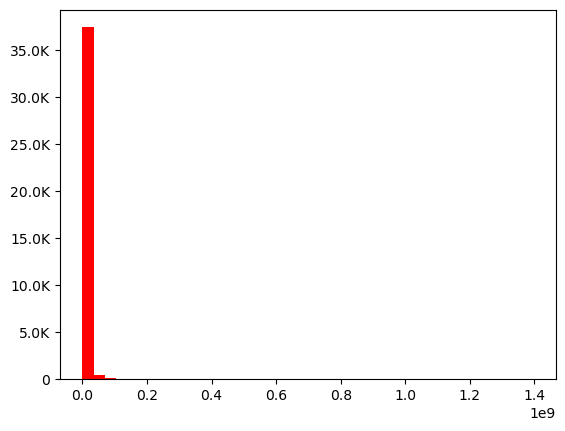

In [12]:
fig, ax = plt.subplots()
hist(ax, df_pyspark_corporate.select('price'), bins = 40, color=['red'])

In [13]:
df_pyspark_corporate.describe().show()    

+-------+-----------------+------------------+------------------+--------+-------------+------------------+--------+------------------+-----------+------------------+------------------+--------------------+------------------+--------------------+-------------+-------------------+-----------------+--------------------+
|summary|sub_property_type|      living_space|   bathroom_number|currency|property_type|       property_id|    city|       floor_level|      state|        built_year|          latitude|             premium|    bedroom_number|             address|listing_label|          longitude|           tenure|               price|
+-------+-----------------+------------------+------------------+--------+-------------+------------------+--------+------------------+-----------+------------------+------------------+--------------------+------------------+--------------------+-------------+-------------------+-----------------+--------------------+
|  count|            38172|             

#####  Dropping Unnecessary Columns

In [14]:
# address has high cardinality

df_pyspark_corporate.select('address').distinct().count()

1597

Address has high cardinality

In [15]:
df_pyspark_corporate = df_pyspark_corporate.drop('address')

In [16]:
df_pyspark_corporate = df_pyspark_corporate.drop('currency', 'listing_label') # constant columns

In [17]:
unique_property_ids = df_pyspark_corporate.select('property_id').distinct().count()
print("Number of unique property IDs:", unique_property_ids)

Number of unique property IDs: 38169


Property_id has a very high cardinality

In [18]:
# both columns increased overfitting
df_pyspark_corporate = df_pyspark_corporate.drop('property_id')

df_pyspark_corporate = df_pyspark_corporate.drop('latitude')
df_pyspark_corporate = df_pyspark_corporate.drop('longitude') 

#### Missing Values

In [19]:
df_pyspark_corporate.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_pyspark_corporate.columns]).show()

+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+
|sub_property_type|living_space|bathroom_number|property_type|city|floor_level|state|built_year|premium|bedroom_number|tenure|price|
+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+
|                0|          49|              0|            0|   0|          0|    0|         0|      0|             0|     0|    0|
+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+



49 missing values for living_space

In [20]:
null_living_space = df_pyspark_corporate.filter(df_pyspark_corporate.living_space.isNull())
null_living_space.show(10)

+-----------------+------------+---------------+-------------+-----------+-----------+-------+----------+-------+--------------+--------+--------+
|sub_property_type|living_space|bathroom_number|property_type|       city|floor_level|  state|built_year|premium|bedroom_number|  tenure|   price|
+-----------------+------------+---------------+-------------+-----------+-----------+-------+----------+-------+--------------+--------+--------+
|         For Sale|        null|              1|        Condo|Khlong Toei|         14|Bangkok|      2018|      0|             2|Freehold|13000000|
|         For Sale|        null|              1|        Condo|Khlong Toei|          2|Bangkok|      2018|      0|             2|Freehold|12890000|
|         For Sale|        null|              1|        Condo|Khlong Toei|          2|Bangkok|      2017|      0|             2|Freehold| 5500000|
|         For Sale|        null|              1|        Condo|Khlong Toei|          5|Bangkok|      2013|      0|     

In [21]:
from pyspark.sql.functions import countDistinct

null_living_space.agg(*[countDistinct(col).alias(col) for col in null_living_space.columns]).show()


+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+
|sub_property_type|living_space|bathroom_number|property_type|city|floor_level|state|built_year|premium|bedroom_number|tenure|price|
+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+
|                1|           0|              1|            1|   1|         23|    1|        10|      1|             1|     1|   39|
+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+



when living_space is null, some columns have specific values.

In [22]:
# imputation from population median
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=['living_space'], 
    outputCols=["{}_imputed".format(c) for c in ['living_space']]
    ).setStrategy("median")

In [23]:
population_median = imputer.fit(df_pyspark_corporate).transform(df_pyspark_corporate)
population_median.filter(population_median.living_space.isNull()).show(5)

+-----------------+------------+---------------+-------------+-----------+-----------+-------+----------+-------+--------------+--------+--------+--------------------+
|sub_property_type|living_space|bathroom_number|property_type|       city|floor_level|  state|built_year|premium|bedroom_number|  tenure|   price|living_space_imputed|
+-----------------+------------+---------------+-------------+-----------+-----------+-------+----------+-------+--------------+--------+--------+--------------------+
|         For Sale|        null|              1|        Condo|Khlong Toei|         14|Bangkok|      2018|      0|             2|Freehold|13000000|                35.0|
|         For Sale|        null|              1|        Condo|Khlong Toei|          2|Bangkok|      2018|      0|             2|Freehold|12890000|                35.0|
|         For Sale|        null|              1|        Condo|Khlong Toei|          2|Bangkok|      2017|      0|             2|Freehold| 5500000|              

In [24]:
population_median = population_median.drop('living_space')

As we can see, when we find the median from the population, the median is 35

In [25]:
filtered_df = df_pyspark_corporate.filter((col("sub_property_type") == "For Sale") &
                                         (col("bathroom_number") == 1) &
                                         (col("property_type") == "Condo") &
                                         (col("city") == "Khlong Toei") &
                                         (col("state") == "Bangkok") &
                                         (col("premium") == 0) &
                                         (col("bedroom_number") == 2) &
                                         (col("tenure") == "Freehold") &
                                         (col("living_space").isNotNull()))

filtered_df.show()


+-----------------+------------+---------------+-------------+-----------+-----------+-------+----------+-------+--------------+--------+--------+
|sub_property_type|living_space|bathroom_number|property_type|       city|floor_level|  state|built_year|premium|bedroom_number|  tenure|   price|
+-----------------+------------+---------------+-------------+-----------+-----------+-------+----------+-------+--------------+--------+--------+
|         For Sale|        55.0|              1|        Condo|Khlong Toei|         31|Bangkok|      2012|      0|             2|Freehold| 4480000|
|         For Sale|        55.0|              1|        Condo|Khlong Toei|         12|Bangkok|      2012|      0|             2|Freehold| 4050000|
|         For Sale|        55.0|              1|        Condo|Khlong Toei|         51|Bangkok|      2018|      0|             2|Freehold|11500000|
|         For Sale|        55.0|              1|        Condo|Khlong Toei|          7|Bangkok|      2013|      0|     

In [26]:
median_value = filtered_df.approxQuantile("living_space", [0.5], 0.001)[0]
print("Median value of living space: ", median_value)

Median value of living space:  55.0


When we find median value from rows with similar attributes, the median is 55

In [27]:
same_attributes_median = df_pyspark_corporate.withColumn("living_space_imputed", when(col("living_space").isNull(), median_value).otherwise(col("living_space")))

same_attributes_median.show()


+-----------------+------------+---------------+--------------+---------+-----------+-------+----------+-------+--------------+--------+--------+--------------------+
|sub_property_type|living_space|bathroom_number| property_type|     city|floor_level|  state|built_year|premium|bedroom_number|  tenure|   price|living_space_imputed|
+-----------------+------------+---------------+--------------+---------+-----------+-------+----------+-------+--------------+--------+--------+--------------------+
|         For Sale|       123.0|              2|Detached House|Nong Chok|          2|Bangkok|      2012|      0|             3|Freehold| 1650000|               123.0|
|         For Sale|       35.35|              1|         Condo| Bang Rak|         56|Bangkok|      2018|      0|             1|Freehold| 7850000|               35.35|
|         For Sale|        40.0|              1|         Condo| Bang Rak|         15|Bangkok|      2016|      1|             1|Freehold| 8400000|                40.0

In [28]:
same_attributes_median = same_attributes_median.drop('living_space')

In [29]:
# When choosing methods

df_pyspark_median = population_median
#df_pyspark_median = same_attributes_median

In [30]:
df_pyspark_median.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_pyspark_median.columns]).show()


+-----------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+--------------------+
|sub_property_type|bathroom_number|property_type|city|floor_level|state|built_year|premium|bedroom_number|tenure|price|living_space_imputed|
+-----------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+--------------------+
|                0|              0|            0|   0|          0|    0|         0|      0|             0|     0|    0|                   0|
+-----------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+--------------------+



#### Outlier Analysis

In [31]:
numeric_columns = [col_name for col_name, col_type in df_pyspark_median.dtypes if col_type in ('int', 'double', 'float')]
numeric_df = df_pyspark_median.select(*numeric_columns)

description = numeric_df.describe()

description.show()


+-------+------------------+------------------+------------------+--------------------+------------------+--------------------+--------------------+
|summary|   bathroom_number|       floor_level|        built_year|             premium|    bedroom_number|               price|living_space_imputed|
+-------+------------------+------------------+------------------+--------------------+------------------+--------------------+--------------------+
|  count|             38172|             38172|             38172|               38172|             38172|               38172|               38172|
|   mean| 1.281122288588494| 16797.51202452059|2014.3310017814104|0.010662265534947082|1.2446819658388348|   6600051.241197737|  128.48079939746447|
| stddev|0.6592253005907419|3216096.7031598454|3.9888989302624926| 0.10270763350055695|0.7432892147066343|1.5041528481160175E7|    6619.50365883316|
|    min|                 0|                 0|              1985|                   0|                 0|

In [32]:
# see which columns have outliers using IQR calculation
outliers_info = []
for col_name in numeric_columns:
    quartiles = df_pyspark_median.approxQuantile(col_name, [0.25, 0.75], 0.001)
    q1 = quartiles[0]
    q3 = quartiles[1]
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Check for outliers in the column
    outliers = df_pyspark_median.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound)).count()

    # Store column name and outlier count in a list
    outliers_info.append((col_name, outliers))

# Print columns with outlier count
for column, outlier_count in outliers_info:
    print(f"Column '{column}' has {outlier_count} outliers.")

Column 'bathroom_number' has 7916 outliers.
Column 'floor_level' has 617 outliers.
Column 'built_year' has 537 outliers.
Column 'premium' has 407 outliers.
Column 'bedroom_number' has 526 outliers.
Column 'price' has 3610 outliers.
Column 'living_space_imputed' has 3500 outliers.


Premium - binary, built_year - date

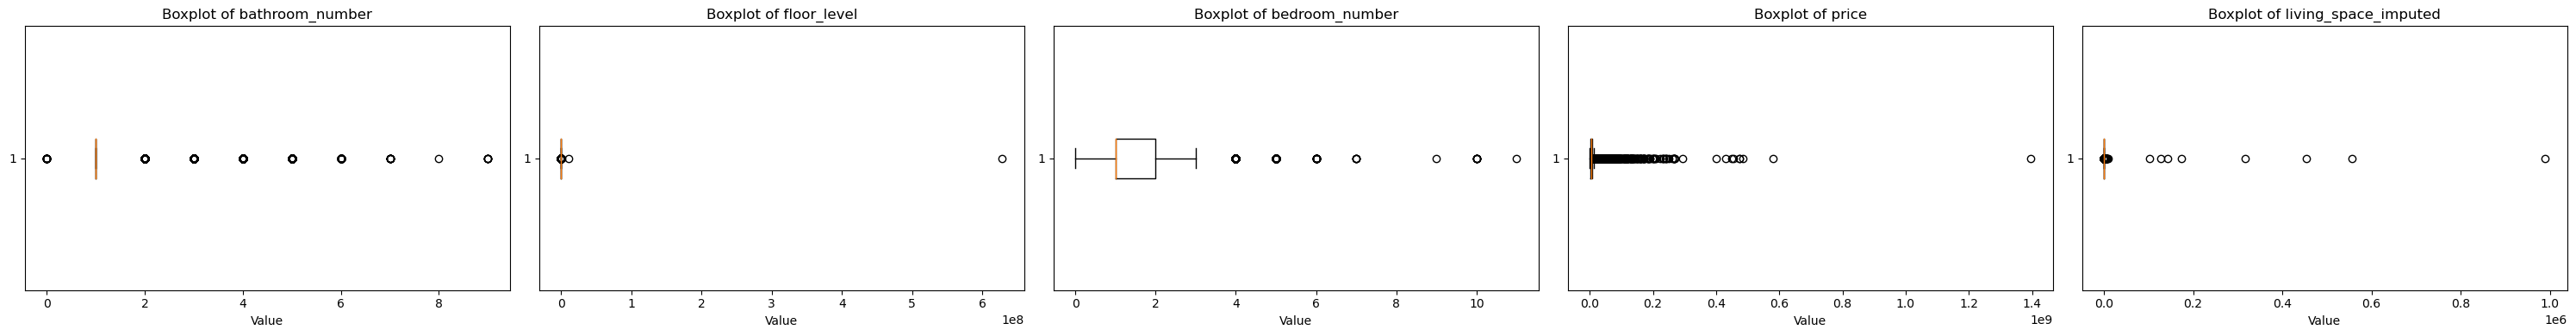

In [33]:
selected_columns = ['bathroom_number', 'floor_level', 'bedroom_number', 'price', 'living_space_imputed']


num_columns = len(selected_columns)
fig, axes = plt.subplots(1, num_columns, figsize=(6 * num_columns, 4))

for i, column in enumerate(selected_columns):
    numeric_data = df_pyspark_median.select(column).rdd.flatMap(lambda x: x).collect()

    # Create a boxplot for each column in a subplot
    axes[i].boxplot(numeric_data, vert=False)
    axes[i].set_xlabel('Value')
    axes[i].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [34]:
# Trimming outliers based on iqr calculation
def trim_outliers(df, col_name):
    quartiles = df.approxQuantile(col_name, [0.25, 0.75], 0.001)
    q1 = quartiles[0]
    q3 = quartiles[1]
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filter the DataFrame to retain data within the bounds
    trimmed_df = df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))
    return trimmed_df

In [35]:
# only do for select features

trim_columns = ['bathroom_number', 'floor_level', 'bedroom_number', 'price', 'living_space_imputed']

trimmed_df = df_pyspark_median

for column in trim_columns:
    trimmed_df = trim_outliers(trimmed_df, column)

trimmed_df.show(5)
print("Number of rows after trimming outliers: {}. Rows trimmed: {}".format(trimmed_df.count(), df_pyspark_median.count() - trimmed_df.count()))


+-----------------+---------------+-------------+--------+-----------+-------+----------+-------+--------------+--------+-------+--------------------+
|sub_property_type|bathroom_number|property_type|    city|floor_level|  state|built_year|premium|bedroom_number|  tenure|  price|living_space_imputed|
+-----------------+---------------+-------------+--------+-----------+-------+----------+-------+--------------+--------+-------+--------------------+
|         For Sale|              1|        Condo|Bang Rak|         15|Bangkok|      2016|      1|             1|Freehold|8400000|                40.0|
|         For Sale|              1|        Condo|Bang Rak|         10|Bangkok|      2010|      1|             1|Freehold|4590000|                37.0|
|         For Sale|              1|        Condo|Bang Rak|         21|Bangkok|      2013|      0|             1|Freehold|5100000|                34.0|
|         For Sale|              1|        Condo|Bang Rak|         25|Bangkok|      2016|     

As we can see trimming removed a lot of rows

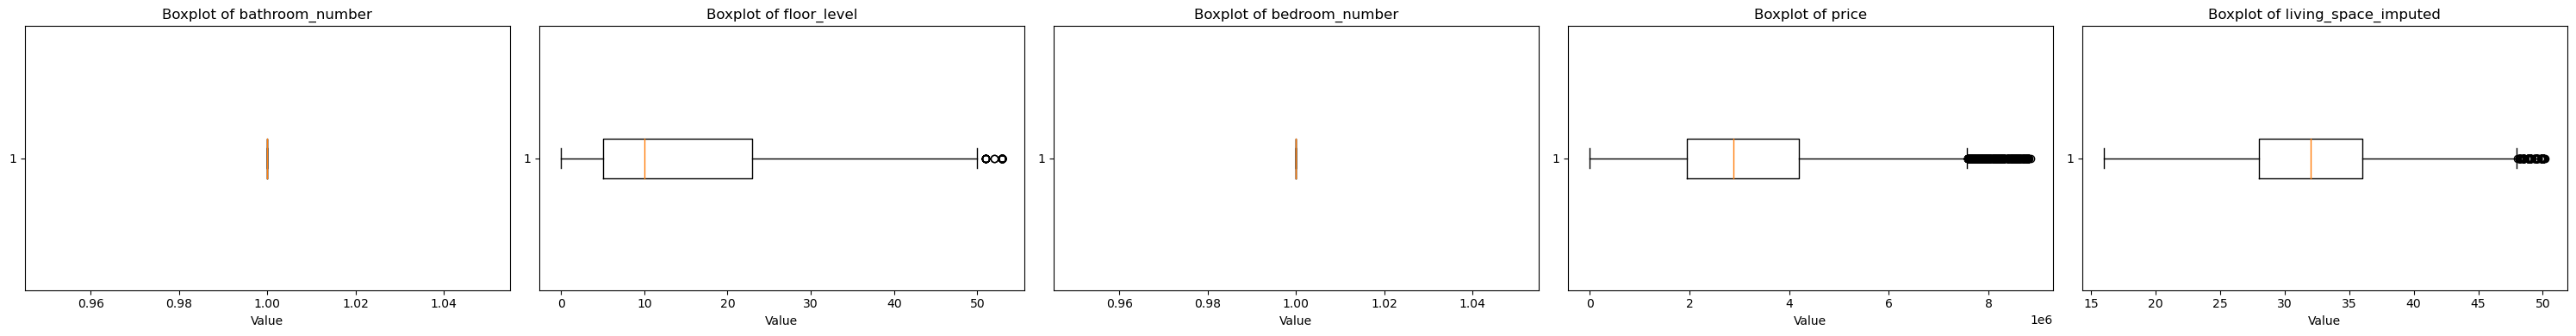

In [36]:
num_columns = len(selected_columns)
fig, axes = plt.subplots(1, num_columns, figsize=(6 * num_columns, 4))

for i, column in enumerate(selected_columns):
    numeric_data = trimmed_df.select(column).rdd.flatMap(lambda x: x).collect()

    # Create a boxplot for each column in a subplot
    axes[i].boxplot(numeric_data, vert=False)
    axes[i].set_xlabel('Value')
    axes[i].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [37]:
from pyspark.sql.functions import col, lit, when


def winsorize(df, col_name, lower_percentile=0.1, upper_percentile=0.90):

    quantiles = df.approxQuantile(col_name, [lower_percentile, upper_percentile], 0.001)
    lower_limit = quantiles[0]
    upper_limit = quantiles[1]

    # Apply winsorization using when() and withColumn()
    winsorized_df = df.withColumn(
        col_name,
        when(col(col_name) < lower_limit, lower_limit)
        .when(col(col_name) > upper_limit, upper_limit)
        .otherwise(col(col_name))
    )
    
    return winsorized_df

In [38]:
# Winsorization for upper bound outliers (all columns other than bathroom_price)

def winsorize_upper_outliers(df, col_name, upper_percentile=0.90): # chaning upper_percentile to 0.90, seems to have removed all the outliers and improved MAE scores
    upper_limit = df.approxQuantile(col_name, [upper_percentile], 0.001)[0]

    # Replace values in the existing column based on winsorization condition
    winsorized_df = df.withColumn(
        col_name,
        when(col(col_name) > upper_limit, upper_limit).otherwise(col(col_name))
    )
    
    return winsorized_df

In [39]:
upper_bound_columns = ['price', 'floor_level', 'bedroom_number', 'living_space_imputed']

winsorized_df = df_pyspark_median

for column in upper_bound_columns:
    winsorized_df = winsorize(winsorized_df, column)

winsorized_df = winsorize(winsorized_df, 'bathroom_number')

In [40]:
winsorized_df.show(5)

+-----------------+---------------+--------------+---------+-----------+-------+----------+-------+--------------+--------+---------+--------------------+
|sub_property_type|bathroom_number| property_type|     city|floor_level|  state|built_year|premium|bedroom_number|  tenure|    price|living_space_imputed|
+-----------------+---------------+--------------+---------+-----------+-------+----------+-------+--------------+--------+---------+--------------------+
|         For Sale|            2.0|Detached House|Nong Chok|        2.0|Bangkok|      2012|      0|           2.0|Freehold|1650000.0|               83.06|
|         For Sale|            1.0|         Condo| Bang Rak|       37.0|Bangkok|      2018|      0|           1.0|Freehold|7850000.0|               35.35|
|         For Sale|            1.0|         Condo| Bang Rak|       15.0|Bangkok|      2016|      1|           1.0|Freehold|8400000.0|                40.0|
|         For Sale|            1.0|         Condo| Bang Rak|       10.

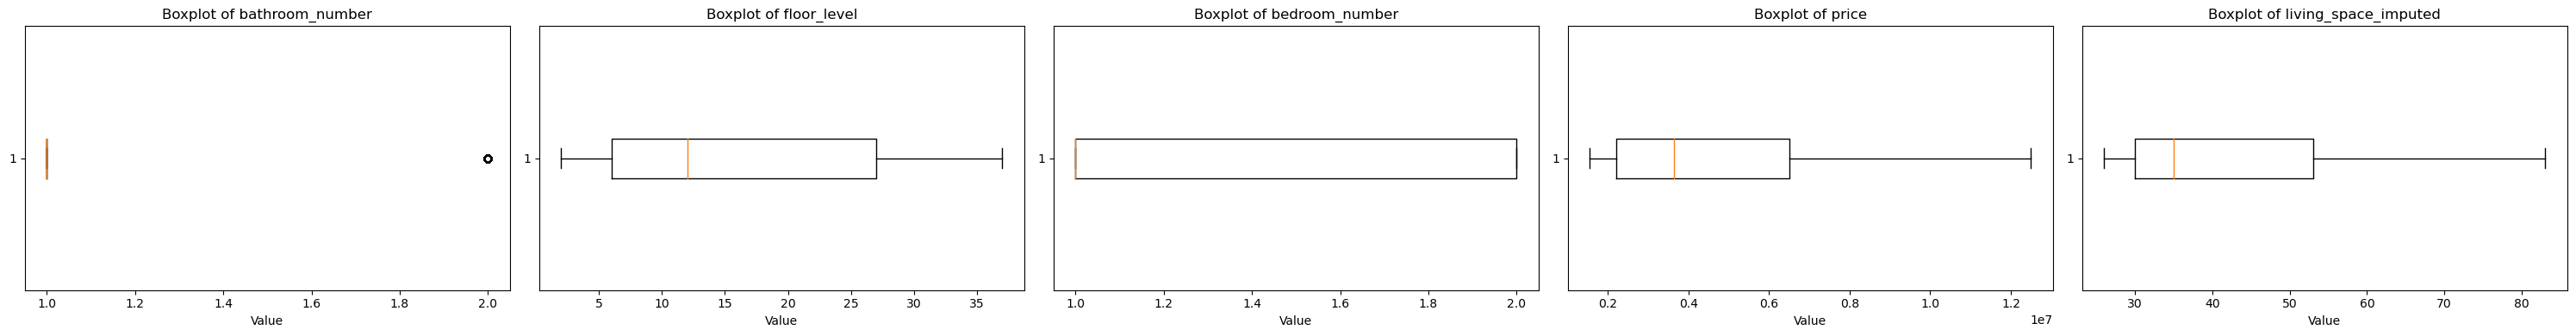

In [41]:
num_columns = len(selected_columns)
fig, axes = plt.subplots(1, num_columns, figsize=(6 * num_columns, 4))

for i, column in enumerate(selected_columns):
    numeric_data = winsorized_df.select(column).rdd.flatMap(lambda x: x).collect()

    # Create a boxplot for each column in a subplot
    axes[i].boxplot(numeric_data, vert=False)
    axes[i].set_xlabel('Value')
    axes[i].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [42]:
print("Number of rows:",winsorized_df.count())

Number of rows: 38172


In [43]:
# be it trimming or wisorization, define final df

#cleaned_df = trimmed_df
cleaned_df = winsorized_df

### Step 3: Data Wrangling and Transformation

#### Grouping rare categories

In [44]:
cleaned_df.agg(*[countDistinct(col).alias(col) for col in cleaned_df.columns]).show()

+-----------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+--------------------+
|sub_property_type|bathroom_number|property_type|city|floor_level|state|built_year|premium|bedroom_number|tenure|price|living_space_imputed|
+-----------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+--------------------+
|                2|              2|            4|  86|         36|   17|        38|      2|             2|     3| 1860|                1842|
+-----------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+--------------------+



In [45]:
relative_freq = cleaned_df.groupBy("city").count().withColumn("relative_frequency", col("count") / cleaned_df.count())
relative_freq.show(86,truncate=False)

+--------------------+-----+---------------------+
|city                |count|relative_frequency   |
+--------------------+-----+---------------------+
|Muang Surat Thani   |1    |2.6197212616577597E-5|
|Phaya Thai          |732  |0.0191763596353348   |
|Bang Kapi           |920  |0.02410143560725139  |
|Bangkok Noi         |183  |0.0047940899088337   |
|Muang Rayong        |5    |1.30986063082888E-4  |
|Ban Bung            |6    |1.5718327569946557E-4|
|Khan Na Yao         |190  |0.004977470397149743 |
|Pathum Wan          |553  |0.01448705857696741  |
|Bang Bua Thong      |114  |0.002986482238289846 |
|Khlong Luang        |84   |0.0022005658597925182|
|Sattahip            |34   |8.907052289636383E-4 |
|Muang Khon Kaen     |1    |2.6197212616577597E-5|
|Muang Chon Buri     |17   |4.4535261448181915E-4|
|Wang Thonglang      |251  |0.006575500366760976 |
|Lak Si              |110  |0.0028816933878235357|
|Prawet              |514  |0.013465367284920884 |
|Hat Yai             |2    |5.2

In [46]:
# 50 threshold - 41 cities
# 100 threshold - 45 cities
filtered_relative_freq = relative_freq.filter(col("count") < 100)
filtered_relative_freq.show(59)
filtered_relative_freq.count()

+--------------------+-----+--------------------+
|                city|count|  relative_frequency|
+--------------------+-----+--------------------+
|   Muang Surat Thani|    1|2.619721261657759...|
|        Muang Rayong|    5| 1.30986063082888E-4|
|            Ban Bung|    6|1.571832756994655...|
|        Khlong Luang|   84|0.002200565859792...|
|            Sattahip|   34|8.907052289636383E-4|
|     Muang Khon Kaen|    1|2.619721261657759...|
|     Muang Chon Buri|   17|4.453526144818191...|
|             Hat Yai|    2|5.239442523315519E-5|
|             Thalang|    2|5.239442523315519E-5|
|           Pak Chong|    3|7.859163784973278E-5|
|          Thanyaburi|   44|0.001152677355129...|
|               Kathu|   42|0.001100282929896...|
|Pom Prap Sattru Phai|    2|5.239442523315519E-5|
|           Sam Phran|   10| 2.61972126165776E-4|
|  Muang Pathum Thani|    5| 1.30986063082888E-4|
|            Min Buri|   37|9.692968668133711E-4|
|          Bang Kruai|   19|4.977470397149744E-4|


44

In [47]:
city_list = [city.city for city in filtered_relative_freq.select('city').collect()]
print(city_list)
print(len(city_list))

['Muang Surat Thani', 'Muang Rayong', 'Ban Bung', 'Khlong Luang', 'Sattahip', 'Muang Khon Kaen', 'Muang Chon Buri', 'Hat Yai', 'Thalang', 'Pak Chong', 'Thanyaburi', 'Kathu', 'Pom Prap Sattru Phai', 'Sam Phran', 'Muang Pathum Thani', 'Min Buri', 'Bang Kruai', 'Bang Saphan', 'Bang Bon', 'Kamphaeng Saen', 'Saphan Sung', 'Lam Luk Ka', 'Nong Chok', 'Bang Khun Thian', 'Nong Khaem', 'Cha-Am', 'Muang Samut Sakhon', 'Hua Hin', 'Pattaya', 'Muang Phuket', 'Thung Khru', 'Don Mueang', 'Ban Laem', 'Sai Noi', 'Si Racha', 'Phra Samut Jadee', 'Bang Klam', 'Bang Yai', 'Sai Mai', 'Taling Chan', 'Bang Sao Thong', 'Phuttha Mon Thon', 'Thawi Watthana', 'Khlong Sam Wa']
44


In [48]:
from pyspark.sql.functions import when
cleaned_df = cleaned_df.withColumn('city', when(cleaned_df['city'].isin(city_list), 'Others').otherwise(cleaned_df['city']))
cleaned_df.show(10)

+-----------------+---------------+--------------+--------+-----------+-------+----------+-------+--------------+--------+---------+--------------------+
|sub_property_type|bathroom_number| property_type|    city|floor_level|  state|built_year|premium|bedroom_number|  tenure|    price|living_space_imputed|
+-----------------+---------------+--------------+--------+-----------+-------+----------+-------+--------------+--------+---------+--------------------+
|         For Sale|            2.0|Detached House|  Others|        2.0|Bangkok|      2012|      0|           2.0|Freehold|1650000.0|               83.06|
|         For Sale|            1.0|         Condo|Bang Rak|       37.0|Bangkok|      2018|      0|           1.0|Freehold|7850000.0|               35.35|
|         For Sale|            1.0|         Condo|Bang Rak|       15.0|Bangkok|      2016|      1|           1.0|Freehold|8400000.0|                40.0|
|         For Sale|            1.0|         Condo|Bang Rak|       10.0|Bangk

In [49]:
state_relative_freq = cleaned_df.groupBy("state").count().withColumn("relative_frequency", col("count") / cleaned_df.count())
state_relative_freq.show(20,truncate=False)

+-------------------+-----+---------------------+
|state              |count|relative_frequency   |
+-------------------+-----+---------------------+
|Chiang Mai         |307  |0.008042544273289322 |
|Nakhon Pathom      |30   |7.859163784973279E-4 |
|Khon Kaen          |1    |2.6197212616577597E-5|
|Nonthaburi         |1328 |0.034789898354815045 |
|Prachuap Khiri Khan|64   |0.0016766216074609662|
|Surat Thani        |1    |2.6197212616577597E-5|
|Samut Prakan       |1607 |0.042098920674840196 |
|Chon Buri          |553  |0.01448705857696741  |
|Songkhla           |3    |7.859163784973278E-5 |
|Phetchaburi        |36   |9.430996541967935E-4 |
|Nakhon Ratchasima  |3    |7.859163784973278E-5 |
|Phuket             |61   |0.0015980299696112333|
|Pattaya            |48   |0.0012574662055957245|
|Samut Sakhon       |18   |4.7154982709839675E-4|
|Bangkok            |33961|0.8896835376715917   |
|Pathum Thani       |146  |0.003824793042020329 |
|Rayong             |5    |1.30986063082888E-4  |


In [50]:
# group states with rows < 10 into Others

filtered_state_relative_freq = state_relative_freq.filter(col("count") < 10)
filtered_state_relative_freq.show(59)
filtered_state_relative_freq.count()

+-----------------+-----+--------------------+
|            state|count|  relative_frequency|
+-----------------+-----+--------------------+
|        Khon Kaen|    1|2.619721261657759...|
|      Surat Thani|    1|2.619721261657759...|
|         Songkhla|    3|7.859163784973278E-5|
|Nakhon Ratchasima|    3|7.859163784973278E-5|
|           Rayong|    5| 1.30986063082888E-4|
+-----------------+-----+--------------------+



5

In [51]:
state_list = [state.state for state in filtered_state_relative_freq.select('state').collect()]
print(state_list)
print(len(state_list))

['Khon Kaen', 'Surat Thani', 'Songkhla', 'Nakhon Ratchasima', 'Rayong']
5


In [52]:
cleaned_df = cleaned_df.withColumn('state', when(cleaned_df['state'].isin(state_list), 'Others').otherwise(cleaned_df['state']))
cleaned_df.show(10)

+-----------------+---------------+--------------+--------+-----------+-------+----------+-------+--------------+--------+---------+--------------------+
|sub_property_type|bathroom_number| property_type|    city|floor_level|  state|built_year|premium|bedroom_number|  tenure|    price|living_space_imputed|
+-----------------+---------------+--------------+--------+-----------+-------+----------+-------+--------------+--------+---------+--------------------+
|         For Sale|            2.0|Detached House|  Others|        2.0|Bangkok|      2012|      0|           2.0|Freehold|1650000.0|               83.06|
|         For Sale|            1.0|         Condo|Bang Rak|       37.0|Bangkok|      2018|      0|           1.0|Freehold|7850000.0|               35.35|
|         For Sale|            1.0|         Condo|Bang Rak|       15.0|Bangkok|      2016|      1|           1.0|Freehold|8400000.0|                40.0|
|         For Sale|            1.0|         Condo|Bang Rak|       10.0|Bangk

In [53]:
cleaned_df.agg(*[countDistinct(col).alias(col) for col in cleaned_df.columns]).show()


+-----------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+--------------------+
|sub_property_type|bathroom_number|property_type|city|floor_level|state|built_year|premium|bedroom_number|tenure|price|living_space_imputed|
+-----------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+--------------------+
|                2|              2|            4|  43|         36|   13|        38|      2|             2|     3| 1860|                1842|
+-----------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+------+-----+--------------------+



##### Numerical Transformation

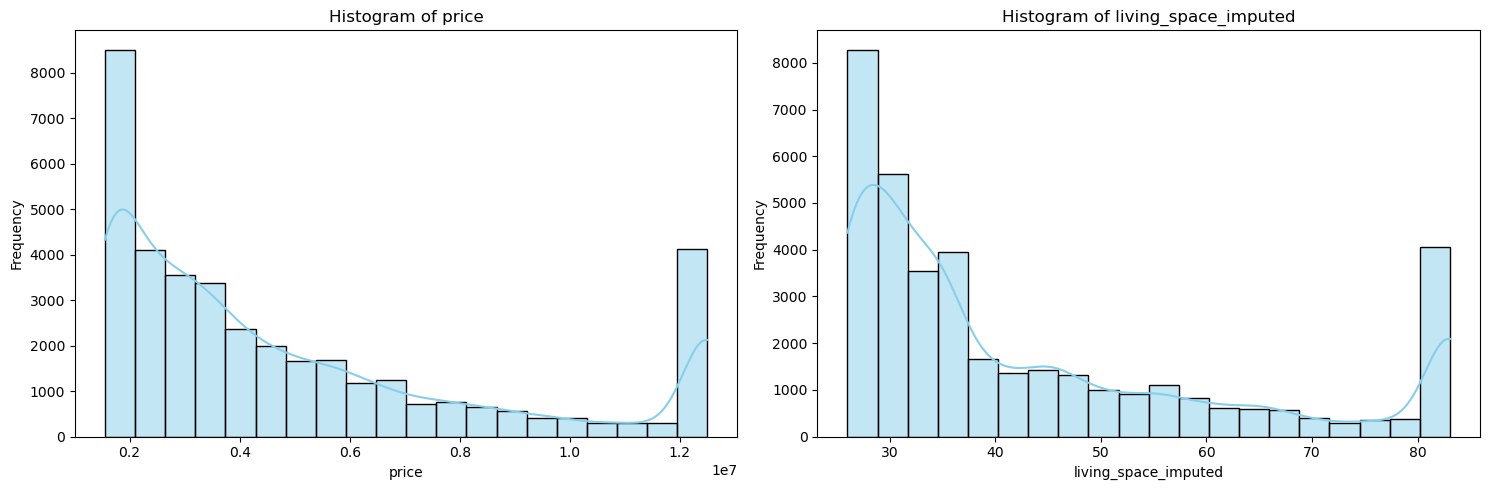

In [54]:
import seaborn as sns

features = ['price', 'living_space_imputed']  # Replace with your feature names
num_bins = 20

# Create subplots for each feature
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15, 5))

for i, feature in enumerate(features):
    # Select the feature column and plot its histogram
    feature_data = cleaned_df.select(col(feature)).rdd.flatMap(lambda x: x).collect()
    sns.histplot(feature_data, bins=num_bins, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

As we can see, our distribution are positively skewed, we can use distribution transformers like log transformer. Since price has values of 0, we need to indicate log(x+1). As pyspark.ml does not have any log transformation modules, we can create a custom transformer or define a transformer, but do not put it in the pipeline

In [55]:
from pyspark.sql.functions import log1p

cleaned_df = cleaned_df.withColumn("price", log1p("price"))
cleaned_df = cleaned_df.withColumn("living_space_imputed", log1p("living_space_imputed"))

In [56]:
#cleaned_df = cleaned_df.drop('price', 'living_space_imputed')
cleaned_df.show()

+-----------------+---------------+--------------+--------+-----------+-------+----------+-------+--------------+--------+------------------+--------------------+
|sub_property_type|bathroom_number| property_type|    city|floor_level|  state|built_year|premium|bedroom_number|  tenure|             price|living_space_imputed|
+-----------------+---------------+--------------+--------+-----------+-------+----------+-------+--------------+--------+------------------+--------------------+
|         For Sale|            2.0|Detached House|  Others|        2.0|Bangkok|      2012|      0|           2.0|Freehold|14.316286451937186|   4.431530829576971|
|         For Sale|            1.0|         Condo|Bang Rak|       37.0|Bangkok|      2018|      0|           1.0|Freehold|15.876024217147117|  3.5931942039795284|
|         For Sale|            1.0|         Condo|Bang Rak|       15.0|Bangkok|      2016|      1|           1.0|Freehold|15.943742382861155|   3.713572066704308|
|         For Sale|   

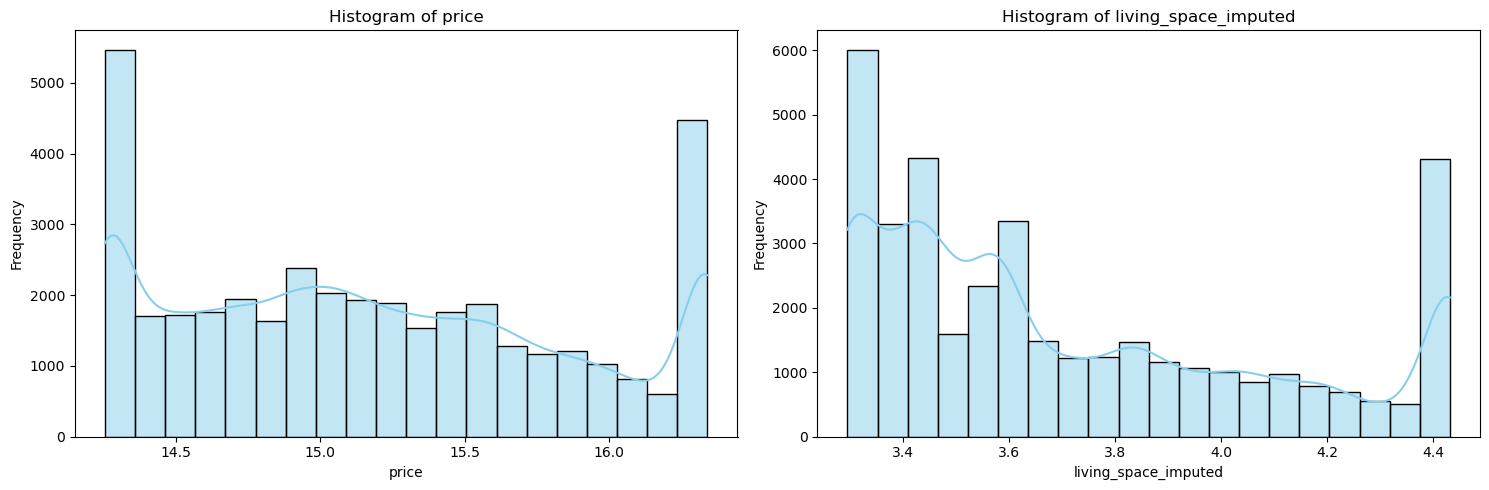

In [57]:
features = ['price', 'living_space_imputed']  # Replace with your feature names
num_bins = 20

# Create subplots for each feature
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15, 5))

for i, feature in enumerate(features):
    # Select the feature column and plot its histogram
    feature_data = cleaned_df.select(col(feature)).rdd.flatMap(lambda x: x).collect()
    sns.histplot(feature_data, bins=num_bins, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### Categorical encoding

In [58]:
# consider categorical and numerical variable treatment and transformations

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [59]:
num_columns = len(cleaned_df.columns)
print("Number of columns in cleaned_df:", num_columns)

Number of columns in cleaned_df: 12


In [60]:
strings_used = [col_name for col_name, col_type in cleaned_df.dtypes if col_type == 'string']
numeric_columns = [col_name for col_name, col_type in cleaned_df.dtypes if col_type in ('int', 'double', 'float') and col_name != 'price' and col_name != 'price_log']  # everything but price, the target variable

stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]


#df_string_indexed = stage_string[0].fit(cleaned_df).transform(cleaned_df)
#df_ohe = stage_one_hot[0].fit(df_string_indexed).transform(df_string_indexed)
#df_ohe.show(5)


In [61]:
print(numeric_columns)

['bathroom_number', 'floor_level', 'built_year', 'premium', 'bedroom_number', 'living_space_imputed']


In [62]:
print(strings_used)

['sub_property_type', 'property_type', 'city', 'state', 'tenure']


##### Vector Assembler

In [63]:
from pyspark.ml.feature import VectorAssembler

assembler_inputs = [col + "_one_hot" for col in strings_used] + numeric_columns # all features but price
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="Xcols")

In [64]:
print(assembler_inputs)

['sub_property_type_one_hot', 'property_type_one_hot', 'city_one_hot', 'state_one_hot', 'tenure_one_hot', 'bathroom_number', 'floor_level', 'built_year', 'premium', 'bedroom_number', 'living_space_imputed']


##### Scaling

In [65]:
from pyspark.ml.feature import StandardScaler

sScaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_scaled") # standardize the features

In [66]:
from pyspark.ml.feature import MinMaxScaler

mmScaler = MinMaxScaler(inputCol="Xcols", outputCol="Xcols_scaled") # normalize the features

##### Principal Component Analysis

In [67]:
from pyspark.ml.feature import PCA

# 37 principal components is around 95% variance
pca = PCA(k=37, inputCol="Xcols_scaled", outputCol="Xcols_final")


##### Train Tests split

In [68]:
# how to we train or test our models?

# Train test split

train, test = cleaned_df.randomSplit([0.7, 0.3], seed=42)

In [69]:
print(type(train))
print(type(test))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [70]:
print((train.count(), len(train.columns)))
print((test.count(), len(test.columns)))

(26880, 12)
(11292, 12)


##### Pipeline

In [71]:
stages = stage_string + stage_one_hot + [assembler, mmScaler]

# rmb to change the feature name to col_one_hot if using one hot encoding and col_string_encoded if using string encoding
#sScaler
# pca
#stages = stage_string + [assembler, mmScaler]

In [72]:
#ppl = Pipeline(stages= stages)

pipeline = Pipeline(stages=stages)

pipeline_model = pipeline.fit(train)
train_transformed = pipeline_model.transform(train)

test_transformed = pipeline_model.transform(test)


#pyspark_index_ohe = ppl.fit(cleaned_df).transform(cleaned_df)
train_transformed.show(5)

+-----------------+---------------+-------------+---------+-----------+-------+----------+-------+--------------+--------+------------------+--------------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+-------------------------+---------------------+---------------+--------------+--------------+--------------------+--------------------+
|sub_property_type|bathroom_number|property_type|     city|floor_level|  state|built_year|premium|bedroom_number|  tenure|             price|living_space_imputed|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|tenure_one_hot|               Xcols|        Xcols_scaled|
+-----------------+---------------+-------------+---------+-----------+-------+----------+-------+--------------+--------+------------------+-----------

In [73]:
test_transformed.show(5)

+-----------------+---------------+-------------+---------+-----------+-------+----------+-------+--------------+--------+------------------+--------------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+-------------------------+---------------------+---------------+--------------+--------------+--------------------+--------------------+
|sub_property_type|bathroom_number|property_type|     city|floor_level|  state|built_year|premium|bedroom_number|  tenure|             price|living_space_imputed|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|tenure_one_hot|               Xcols|        Xcols_scaled|
+-----------------+---------------+-------------+---------+-----------+-------+----------+-------+--------------+--------+------------------+-----------

In [74]:
# Clean up the data

train_data = train_transformed.select("Xcols_scaled","price")
test_data = test_transformed.select("Xcols_scaled","price")

### Step 4: Machine Learning Modelling

In [75]:
# after splitting, train & test has 12 columns including price
print((train.count(), len(train.columns)))
print((test.count(), len(test.columns)))

(26880, 12)
(11292, 12)


In [76]:
# pre modelling dataset has only 2 columns due to vector assemble
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(26880, 2)
(11292, 2)


In [77]:
train_data.show(10)

+--------------------+------------------+
|        Xcols_scaled|             price|
+--------------------+------------------+
|(66,[0,1,17,46,58...|14.253766134056512|
|(66,[0,1,17,46,58...|14.253766134056512|
|(66,[0,1,17,46,58...|14.253766134056512|
|(66,[0,1,17,46,58...|14.253766134056512|
|(66,[0,1,17,46,58...|14.266586814266963|
|(66,[0,1,17,46,58...|14.346139397261565|
|(66,[0,1,17,46,58...|14.253766134056512|
|(66,[0,1,17,46,58...|14.253766134056512|
|(66,[0,1,17,46,58...|14.285514812209815|
|(66,[0,1,17,46,58...|14.316286451937186|
+--------------------+------------------+
only showing top 10 rows



In [78]:
test_data.show(10)

+--------------------+------------------+
|        Xcols_scaled|             price|
+--------------------+------------------+
|(66,[0,1,17,46,58...|14.253766134056512|
|(66,[0,1,17,46,58...|14.316286451937186|
|(66,[0,1,17,46,58...|14.503645699213111|
|(66,[0,1,17,46,58...|14.528460856016357|
|(66,[0,1,17,46,58...|14.316286451937186|
|(66,[0,1,17,46,58...|14.316286451937186|
|(66,[0,1,17,46,58...|14.316286451937186|
|(66,[0,1,17,46,58...|14.375126917328105|
|(66,[0,1,17,46,58...|14.436087583323648|
|(66,[0,1,17,46,58...|14.498607907721096|
+--------------------+------------------+
only showing top 10 rows



##### Linear Regression

In [79]:
# use code to show number of rows and columns,
# as well as a sample of 10 rows before heading into Machine Learning Modelling

In [80]:
from pyspark.ml.regression import LinearRegression

regressor=LinearRegression(featuresCol="Xcols_scaled", labelCol='price')
regressor=regressor.fit(train_data)

In [81]:
type(regressor)

pyspark.ml.regression.LinearRegressionModel

##### Decision Tree Regressor

In [82]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dtc = DecisionTreeRegressor(featuresCol="Xcols_scaled", labelCol="price")
dtc_model = dtc.fit(train_data)

In [83]:
pred = dtc_model.transform(test_data)
pred.show(3)

+--------------------+------------------+------------------+
|        Xcols_scaled|             price|        prediction|
+--------------------+------------------+------------------+
|(66,[0,1,17,46,58...|14.253766134056512| 14.42349418253816|
|(66,[0,1,17,46,58...|14.316286451937186|14.760369075804316|
|(66,[0,1,17,46,58...|14.503645699213111|14.760369075804316|
+--------------------+------------------+------------------+
only showing top 3 rows



### Step 5: Model Evaluation and Selection

##### Linear Regression

In [84]:
train_pred_results=regressor.evaluate(train_data)

In [85]:
train_pred_results.predictions.show()

+--------------------+------------------+------------------+
|        Xcols_scaled|             price|        prediction|
+--------------------+------------------+------------------+
|(66,[0,1,17,46,58...|14.253766134056512| 14.22998538106315|
|(66,[0,1,17,46,58...|14.253766134056512|14.238946625071817|
|(66,[0,1,17,46,58...|14.253766134056512|14.249376805508678|
|(66,[0,1,17,46,58...|14.253766134056512|14.410423711075683|
|(66,[0,1,17,46,58...|14.266586814266963|14.376559384179041|
|(66,[0,1,17,46,58...|14.346139397261565|14.376559384179041|
|(66,[0,1,17,46,58...|14.253766134056512|14.370148543386366|
|(66,[0,1,17,46,58...|14.253766134056512|14.442225347301177|
|(66,[0,1,17,46,58...|14.285514812209815| 14.57583497266224|
|(66,[0,1,17,46,58...|14.316286451937186|14.406210553966357|
|(66,[0,1,17,46,58...|14.340239678615058|14.387765095418382|
|(66,[0,1,17,46,58...|14.375126917328105|14.330557812364608|
|(66,[0,1,17,46,58...|14.375126917328105|14.406210553966357|
|(66,[0,1,17,46,58...|14

In [86]:
test_pred_results=regressor.evaluate(test_data)

In [87]:
test_pred_results.predictions.show()

+--------------------+------------------+------------------+
|        Xcols_scaled|             price|        prediction|
+--------------------+------------------+------------------+
|(66,[0,1,17,46,58...|14.253766134056512|14.249376805508678|
|(66,[0,1,17,46,58...|14.316286451937186|14.410423711075683|
|(66,[0,1,17,46,58...|14.503645699213111|14.376559384179041|
|(66,[0,1,17,46,58...|14.528460856016357|14.376559384179041|
|(66,[0,1,17,46,58...|14.316286451937186|14.330557812364608|
|(66,[0,1,17,46,58...|14.316286451937186|14.330557812364608|
|(66,[0,1,17,46,58...|14.316286451937186|14.370148543386366|
|(66,[0,1,17,46,58...|14.375126917328105|14.406210553966357|
|(66,[0,1,17,46,58...|14.436087583323648|14.582119590988585|
|(66,[0,1,17,46,58...|14.498607907721096|14.406210553966357|
|(66,[0,1,17,46,58...|14.508658238524095|14.406210553966357|
|(66,[0,1,17,46,58...| 14.45736497045232| 14.43973469773351|
|(66,[0,1,17,46,58...|14.253766134056512|14.316545144446907|
|(66,[0,1,17,46,58...|14

In [88]:
train_pred_results.meanAbsoluteError, train_pred_results.meanSquaredError, train_pred_results.r2

(0.21361743531763533, 0.08264805943788524, 0.816880592455355)

In [89]:
test_pred_results.meanAbsoluteError, test_pred_results.meanSquaredError, test_pred_results.r2

(0.21585363406622066, 0.0863060108283578, 0.8079664362778196)

##### Decision Tree Regressor

In [90]:
mae_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

mae = mae_evaluator.evaluate(pred)
r2 = r2_evaluator.evaluate(pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2: {r2}")

Mean Absolute Error (MAE): 0.2720095304152143
R2: 0.7103584970694203


In [91]:
feature_importances = dtc_model.featureImportances
print("Feature Importances:")
for i, feature in enumerate(assembler_inputs):
    print(f"{feature}: {feature_importances[i]}")

Feature Importances:
sub_property_type_one_hot: 0.0
property_type_one_hot: 0.0
city_one_hot: 0.0
state_one_hot: 0.015789613974722175
tenure_one_hot: 0.0
bathroom_number: 0.015313604753017403
floor_level: 0.0
built_year: 0.0010763581796253492
premium: 0.0
bedroom_number: 0.0
living_space_imputed: 0.0


### Step 6: Report

### Table of Contents

- [Problem Statement Formulation](#introduction)
- [Exploratory Data Analysis and Data Cleaning](#eda&cleaning)
- [Data Wrangling and Transformation](#multipletables)
- [Machine Learning Modelling](#model)
- [Model Evaluation and Selection](#metrics)
- [Summary and Further Improvements](#summary)

### Problem Statement Formulation

The dataset used for the project is on property prices in Thailand. The dataset largely comprises geospatial details such as the state and city of the property, details of the property such as number of bedrooms and living space and details of property ownership. 

When looking through the address column, I observed that there is a mix of English, Thai and error values. It may be hard to work with this column as English and Thai words have a lot of differences. For example, the Thai script is largely written without spaces between words, unlike English. The error values also show that some address texts were not supported by Excel.

I also observed that currency has only one value, Baht which shows that the price values all are standardized in the same currency. 

Problem Statement: A building company intends to implement a price prediction model to predict the price and profitability of its upcoming properties.
A price prediction model would be able to help the company in resource allocation, investment decisions and project prioritization based on profitability..


Additionally, since property projects will be under the building company, its listing label would be corporate. To create a more relevant dataset, I narrowed the listing labels to only corporate listings.

### Exploratory Data Analysis and Data Cleansing

First, I explored the numerical predictor features using summary statistics. 

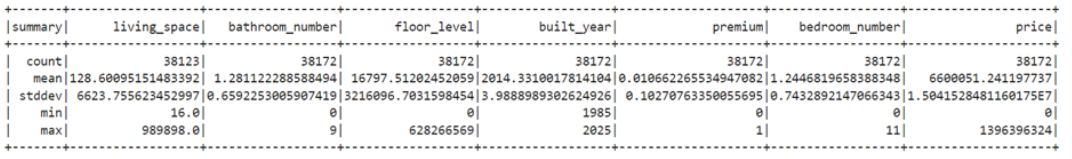

Here, I observed that the feature premium is a binary variable, the maximum value of built_year is 2025 and the minimum value is 1985, indicating that the dataset consists of already built and upcoming properties. I also observed that floor level and living space maximum values are too high to be feasible, this shows there could be outliers in these features. Average prices are 66,00,051 baht.

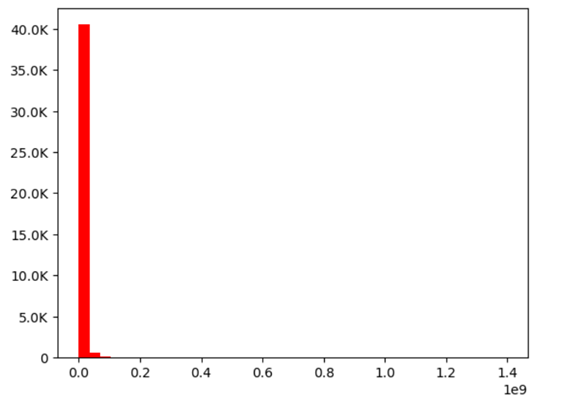

Next, I plotted the distribution of the target variable, price. As we can see, most price values are between 0 and 200,000,000. 

#### Dropping

Next, I dropped address, currency, listing_label, property_id, latitude and longitude.
Address was dropped due to its high cardinality as well as language mismatch, making cleaning and feature extraction difficult. Currency and listing_label were dropped as they only consisted of one value and were unable to provide useful information. Property_id was dropped as it was an ID column with no additional information to provide for the model other than property identification. Latitude and longitude were dropped as there are already location features like city and state which make them redundant and increase the risk of model overfitting.


#### Missing values
Next, I found that living_space has 49 missing values. I found that when living_space is null, some columns have specific values (eg property_type = Condo). When I imputed the missing data, I tried imputing with the population median and with the median value of rows with the specific values. I wanted to see if the missing data had relations with other columns and by capturing these relationships, improve model performance. Population median performed slightly better, showing that there was little relation between missing data and other features. 



#### Outliers

For outliers, I used IQR calculations to detect which features had outliers.


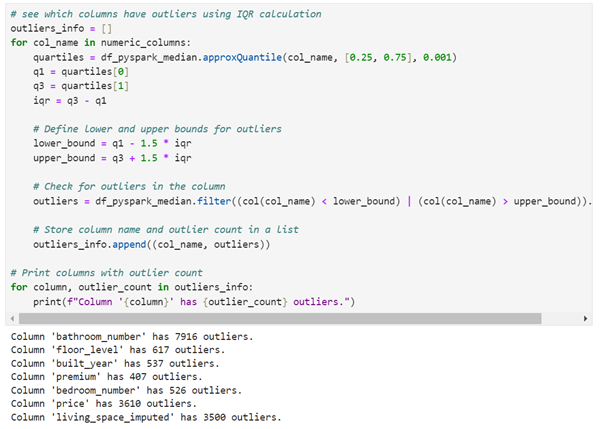

I decided not to do outlier cleaning for premium as it is a binary variable and built_year as it is a date value. I tried both trimming based on IQR and winsorization. Trimming resulted in too many rows being dropped and heavily impacted model performance hence I used winsorization instead. 

Before outlier cleansing

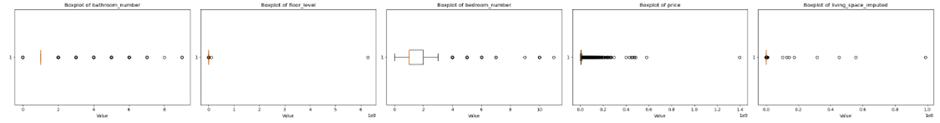

After outlier cleansing

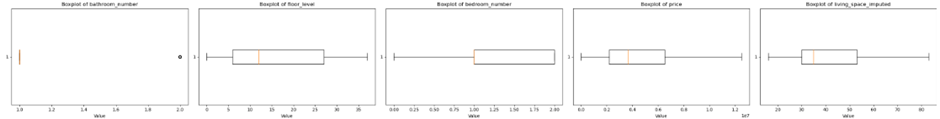

### Data Wrangling and Transformation

#### Rare categories

Here, I grouped rare categories in city and state. Grouping helped to reduce the cardinality of features which reduces dataset complexity. It also helped to ensure consistency between test and train data as values with very few rows can be present in the test and not the train after splitting, resulting in them not being encoded. 

#### Numerical Transformation

Next, I performed distribution transformation. Many models assume data normality and distribution transformers can make skewed or non-normally distributed data more symmetric, aligning better with model assumptions. I also only transformed price and living_space_imputed as they have a continuous range of values that distribution transformers are more suited for.

Before transformation:

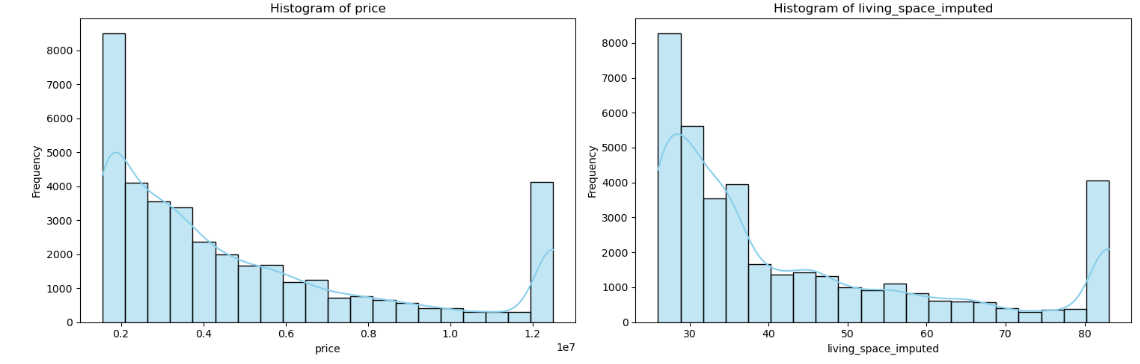

As we can see, the distributions are positively skewed, hence, I used a log transformer. Since price has values of 0, I indicated log(x+1).

After transformation with upper bound winsorizer:

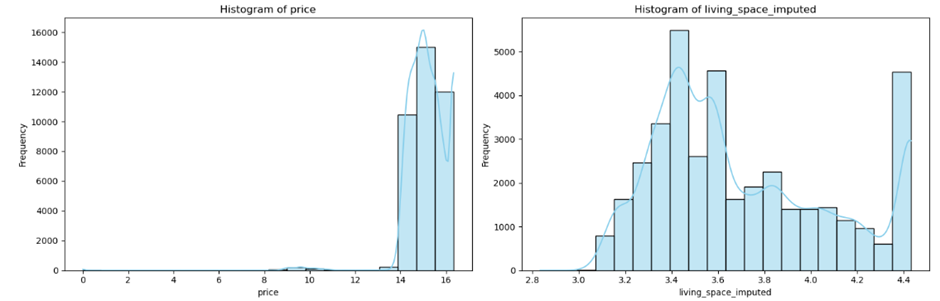

A problem I faced with the price variable is when I apply log on upper bound winsorized values, the price distribution becomes extremely left skewed. This is due to the wide spread of values in price and the presence of 0 values. 

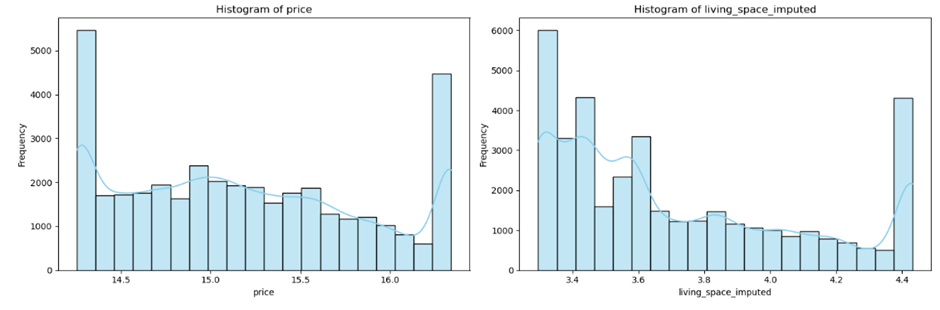

Hence, when I did log transform, I also performed winsorization on both upper and lower bounds to replace 0 values as well.

#### Categorical Encoding


Next, I did encoding for categorial features. This is done as some models such as linear regression require numerical variables as inputs. Here, I tried label encoding using StringIndexer and OHE. I chose to use OHE in the end as a common problem with label encoding is that it causes the model to assume ordinality in the data. Since my data was not ordinal, I used OHE instead. The model performed better with OHE as well. 

#### Others

Afterwards, I used Vector Assembler to combine the predictor features into a single column as most Pyspark ML algorithms require single-column inputs.

Next, I did scaling to ensure all the variables had the same value range and prevent model bias towards features that have larger scales. Here, I tried Min Max and standard scaling. While standard scaling assumes data normality, min-max does not assume the data distribution. Since, my data, even after distribution transformations, were not completely Gaussian, I opted to use min-max scaling. 

Lastly, I tried Principal Component Analysis for dimensionality reduction and to capture the most important features. However, it worsened model performance. This could be due to PCA not preserving non-linear relationships in the data. Due to worsened performance, I did not use PCA


### Machine Learning Modelling 

Due to vector assembly, the total number of columns of the pre-modelling dataset is 2, predictor features and price. There are 26880 rows in train and 11292 rows in test. For reference, before transformation, train and test had 12 columns including price. 

Since the price variable is continuous, it is a regression problem. For the models, I chose to use Linear Regression and Decision Trees. 

Linear regression is a simple model that is easy to implement for regression problems. Linear regression predicts the relationships between two variables and seeks the optimal line that minimizes the sum of squared differences between predicted and actual values. However, a downside to linear regression is that it assumes linear relationships between predictor features and target.

Decision trees are also a simple and easily interpretable model that can be used for classification and regression problems. The model uses a recursive partitioning process, where each node is divided into child nodes and the process is continued until a stopping criterion is met. Decision trees are capable of capturing non-linear relationships between predictors and targets. However, decision trees are highly sensitive to noise and small changes in the data can lead to different tree structures, causing instability in the model

### Model Evaluation and Selection

For both models, I used Mean Absolute Error (MAE) and R-squared metrics for evaluation. MAE measures the average value of errors between the predicted and actual values. It represents the average absolute difference between predicted and actual values. R-squared measures the proportion of variance in the target variable that is explained by the predictor variables. It indicates how well the model fits the data compared to a simple mean baseline.

Linear regression: MAE: 0.21585, R-squared: 0.8079

Decision Trees: MAE: 0.2718, R-squared: 0.7091


MAE results are in decimal place due to log transformation done on target variable. An MAE of 0.2158 means that there is an average deviation of 21.58% from actual values in the original scale. 

I chose these two models because while they are both regression models, their capabilities are different. Linear regression best captures linear and normally distributed variables but is limited in handling complex relationships and non-linear patterns. Decision trees conversely can capture non-linear and complex patterns better.
 
Overall, I chose linear regression as it had a higher R-square score and a lower MAE, indicating that Linear regression can better fit the data and has lower prediction errors on average. This also shows that the relationships between predictors and target variables were closer to linear, allowing linear regression to perform better. 


### Summary

Problem Statement is to build a price prediction model for a building company to predict price and profitability. 

In data exploration, I found that there is a language mismatch in address column and dropped it. I also found that all the prices were standardized in Baht, the Thai currency.

Dropped currency, listing_label, property_id, latitude and longitude as well due to the features not being able to provide useful information or were redundant.

For missing values, I imputed with population median as there were no relations between missing data and features. For outliers, I used upper and lower bound winsorization. 

For rare categories, i grouped city and state values as they had high cardinalities. I performed log transformation on price and living_space_imputed. Here, I found out that I had to use upper and lower bound winsorization due to 0 values. Used one-hot encoding for categorical features, did min-max scaling. Tried PCA for dimensionality reduction, however, did not help model performance. 

For machine learning, used Linear Regression and Decision Trees, linear regression fit the data better and had smaller prediction errors. This implies that the relationship between predictor and target variables were more linear. 

Further Improvements

Some further improvements would be to try more models to see whether they perform better on my dataset. I can also use GridSearch and ensemble methods for better model performance. Lastly, explore more on non-linear relationships in the data and the transformations for them.
